# Test simulating compendia by latent transformation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import umap
import glob
from keras.models import load_model
from sklearn.decomposition import PCA
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models
train_vae_modules.set_all_seeds()

In [3]:
# Read in config variables
config_filename = "config_simulate_by_latent_transform.tsv"
params = utils.read_config(config_filename)

In [4]:
# Load parameters
local_dir = params["local_dir"]
raw_compendium_filename = params["raw_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]
latent_dim = params["latent_dim"]
vae_model_dir = params["vae_model_dir"]
training_stats_dir = params["training_stats_dir"]
metadata_filename = params["metadata_filename"]
metadata_delimiter = params["metadata_delimiter"]
experiment_id_colname = params['metadata_experiment_colname']
sample_id_colname = params['metadata_sample_colname']
experiment_id_filename = params["experiment_ids_filename"]
num_simulated_experiments = params['num_simulated']

In [5]:
assert os.path.exists(raw_compendium_filename)

## Setup directories

In [6]:
utils.setup_dir(config_filename)

## Pre-process data

In [7]:
train_vae_modules.normalize_expression_data(config_filename,
                                            raw_compendium_filename,
                                            normalized_compendium_filename)

input: dataset contains 273 samples and 5000 genes
Output: normalized dataset contains 273 samples and 5000 genes


In [8]:
utils.create_experiment_id_file(metadata_filename,
                                normalized_compendium_filename,
                                experiment_id_filename,
                                config_filename)

There are 3220 experiments in the compendium
There are 9 experiments with gene expression data
9 experiment ids saved to file


## Train VAE

input dataset contains 273 samples and 5000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 246 samples, validate on 27 samples
Epoch 1/10
246/246 [==============================] - 22s 89ms/step - loss: 2340.0547 - kl_loss: 13.9695 - recons_loss: 2340.0549 - val_loss: 2576.0480 - val_kl_loss: 138.0642 - val_recons_loss: 2576.0481
Epoch 2/10
246/246 [==============================] - 21s 84ms/step - loss: 2167.1976 - kl_loss: 13.5955 - recons_loss: 2167.1978 - val_loss: 2336.1353 - val_kl_loss: 78.0170 - val_recons_loss: 2336.1355
Epoch 3/10
246/246 [==============================] - 21s 85ms/step - loss: 2154.3729 - kl_loss: 13.6481 - recons_loss: 2154.3733 - val_loss: 2209.4283 - val_kl_loss: 48.0266 - val_recons_loss: 2209.4282
Epoch 4/10
246/246 [==============================] 

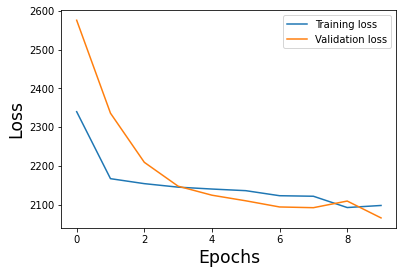

In [9]:
# Train VAE
train_vae_modules.train_vae(config_filename,
                            normalized_compendium_filename)

## Simulate data by latent transformation

In [10]:
# Run simulation
simulated_data = simulate_expression_data.simulate_by_latent_transformation(
    num_simulated_experiments,
    normalized_compendium_filename,
    vae_model_dir,
    latent_dim,
    metadata_filename,
    metadata_delimiter,
    experiment_id_colname,
    sample_id_colname,
    experiment_id_filename,
    local_dir,
)

Normalized gene expression data contains 273 samples and 5000 genes
Return: simulated gene expression data containing 1766 samples and 5001 genes


## Visualize latent transform compendium

In [11]:
# Load VAE models
model_encoder_filename = glob.glob(os.path.join(
        vae_model_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_filename)
loaded_decode_model = load_model(model_decoder_filename)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

In [12]:
pca = PCA(n_components=2)

In [13]:
# Read data
normalized_compendium = pd.read_csv(normalized_compendium_filename, header=0, sep="\t", index_col=0)

In [14]:
# Encode normalized compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=normalized_compendium.index)

# Get and save PCA model
model = pca.fit(compendium_encoded_df)

compendium_PCAencoded = model.transform(compendium_encoded_df)

compendium_PCAencoded_df = pd.DataFrame(data=compendium_PCAencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_PCAencoded_df['experiment_id'] = 'background'

In [15]:
# Embedding of real template experiment (encoded)
before_encoded_filename = os.path.join(local_dir, "simulated_before_encoded.tsv")

template_encoded_df = pd.read_csv(before_encoded_filename, header=0, sep='\t', index_col=0)

template_PCAencoded = model.transform(template_encoded_df)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_PCAencoded_df['experiment_id'] = 'template_experiment'

In [16]:
# Embedding of simulated experiment (encoded)
after_encoded_filename = os.path.join(local_dir, "simulated_after_encoded.tsv")

simulated_encoded_df = pd.read_csv(after_encoded_filename,header=0, sep='\t', index_col=0)

simulated_PCAencoded = model.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['experiment_id'] = 'simulated_experiment'

In [17]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(291, 3)


,1,2,experiment_id
SRR493816,2.181720,-0.058326,background
SRR493817,2.268133,0.311650,background
SRR547975,2.760162,-1.434468,background
SRR547973,2.580462,-0.012019,background
SRR547968,2.977071,-0.524690,background


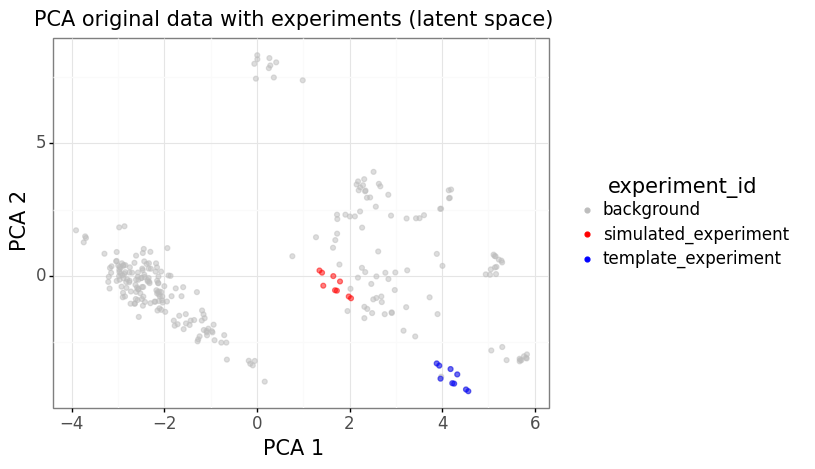

<ggplot: (8792287502157)>


In [18]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.5)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'after_experiment'],
                  alpha=0.2, 
                  color='red')
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'before_experiment'],
                  alpha=0.2, 
                  color='blue')

print(fig)